In [1]:
import jax, jax.numpy as jnp, jax.random as jr
from minirl.cliff import Cliff
from minirl.util import Env
from minirl.model import Embedding, EpsGreedy, TemperatureSampler, ExpSchedule
from minirl.ppo import ep_weighted_expected_reward, rtg_expected_reward
from minirl.buf import SeqBuf
from tqdm import trange
import pandas as pd, matplotlib.pyplot as plt, matplotlib.animation as animation, typing

plt.rcParams["animation.html"] = "jshtml" # ensure animations work
key = jr.key(42 + 1337)

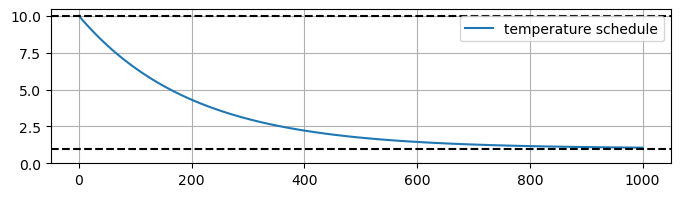

In [2]:
sched = ExpSchedule(a=9., b=-5e-3, c=1.)
plt.figure(figsize=(8,2))
plt.grid(True)
plt.plot(*zip(*[(i, sched(i)) for i in jnp.linspace(0,1000,100)]), label="temperature schedule")
plt.axhline(1., c="k", ls="--")
plt.axhline(10., c="k", ls="--")
plt.ylim(0)
plt.legend();

In [3]:
# create an environment
env = Cliff()

# create a model
emb = Embedding(4*12, 4)
key, model_key = jr.split(key)
model = TemperatureSampler(emb, sched)
params_init, state_init = model.init(model_key)
params, state, returns, entropies, num_eps, snapshots = params_init, state_init, [], [], [], []

In [4]:
buf = SeqBuf(buf_size=200, max_episode_len=env.max_steps)
buf_state = buf.empty()

In [5]:
for epoch in (pbar := trange(2000)):
    buf_state = buf_state.reset()
    buf_state = buf.fill_buffer(buf_state, key, model, params, state, env)

    # obtain policy gradient
    grads = jax.grad(rtg_expected_reward, argnums=1)(model, params, state, buf, buf_state)

    # bookkeeping
    log_probs = jax.nn.log_softmax(params)
    entropy = (-jnp.mean(log_probs * jnp.exp(log_probs))).item()
    entropies.append(entropy)
    returns.append(buf.get_avg_return(buf_state).item())
    num_eps.append(buf_state.num_eps.item())
    pbar.set_description(f"avg_ret={returns[-1]:8.02f} num_eps={buf_state.num_eps:3d}")
    if epoch % 100 == 0:
        tau = model.sched(state)
        snapshots.append((epoch, tau, jax.nn.softmax(params / tau)))

    # update model params and its state
    params = jax.tree_util.tree_map(lambda p, g: p + 1e-2 * g, params, grads)
    state = model.step(state)

avg_ret=    0.00 num_eps=  8: 100%|██████████| 2000/2000 [00:28<00:00, 70.88it/s]


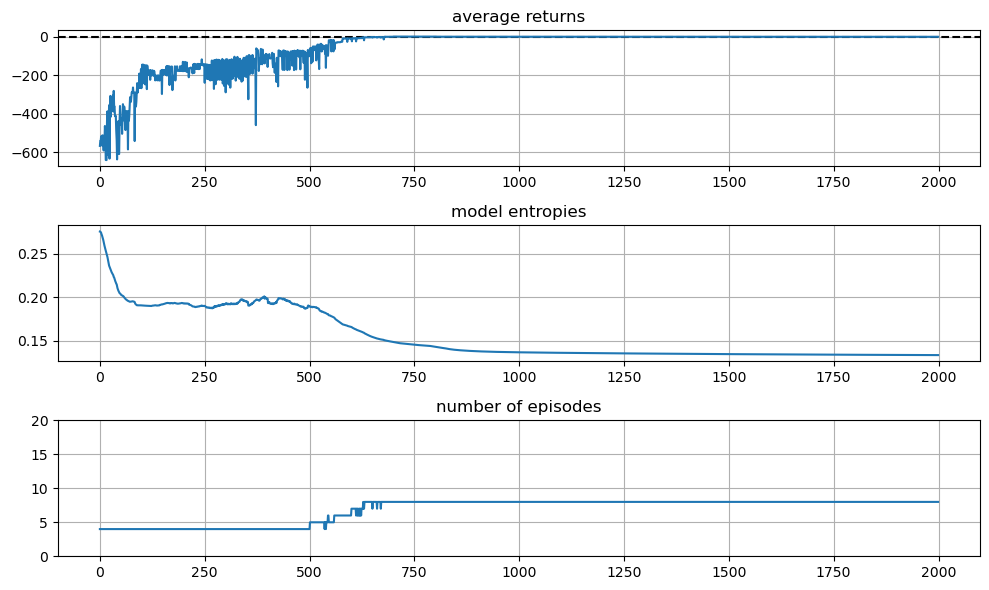

In [6]:
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.axhline(0, ls="--", c="k")
pd.Series(returns).plot.line(grid=True, title="average returns")
plt.subplot(3,1,2)
pd.Series(entropies).plot.line(grid=True, title="model entropies")
plt.subplot(3,1,3)
plt.ylim(0,20)
pd.Series(num_eps).plot.line(grid=True, title="number of episodes")
plt.tight_layout();

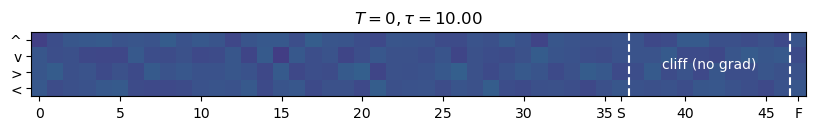

In [7]:
fig, ax = plt.subplots(figsize=(10,2))
def update(frame):
    epoch, tau, snapshot = snapshots[frame]
    title = ax.set_title("$T=%d,\\tau=%.02f$" % (epoch, tau))
    #xticks = ax.set_xticks([0,5,10,15,16,20,23], ["0","5","10","15","S","20","F"])
    xticks = [(i,str(i)) for i in range(0,4*12,5)] + [(3*12+0,"S"), ((3*12+11,"F"))]
    xticks = ax.set_xticks(*zip(*xticks))
    yticks = ax.set_yticks(range(4), [*Cliff().ACTION2CHAR.values()])
    imshow = ax.imshow(snapshot.T, vmin=0, vmax=1)
    return title, xticks, yticks, imshow
# NB: cliff spots don't get gradient, but they are subject to changes in temperature -> their color will change when the temperature changes
start_cliff, end_cliff = 37, 46
ax.axvline(start_cliff - .5, c="w", ls="--")
ax.axvline(end_cliff + .5, c="w", ls="--")
ax.text(start_cliff + (end_cliff - start_cliff) / 2, 1.5, "cliff (no grad)", c="w", ha="center", va="center")
animation.FuncAnimation(fig=fig, func=update, frames=len(snapshots), interval=50)